In [17]:
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
import itertools
import calendar
%matplotlib inline
sns.set()

In [18]:
data_sample = pd.read_csv('20171016-210106-DataSample.csv',dtype={"value": float})
data_sample2 = pd.read_csv('20171016-210304-DataSample.csv',dtype={"value": float})
data_sample3 = pd.read_csv('20171016-210529-DataSample.csv',dtype={"value": float})
data_sample4 = pd.read_csv('20171016-235959-DataSample.csv',dtype={"value": float})

data_sample = data_sample.append([data_sample2,data_sample3,data_sample4])
data_sample['startDate'] = pd.to_datetime(data_sample['startDate']) 
data_sample['owner'].replace('00000000-5854-8d6f-b8eb-cf14a0f795df','00000000-56ff-538b-2223-e1800b5e3ddb',inplace=True)
data_sample['startDate'] = pd.to_datetime(data_sample['startDate'])
data_sample['endDate'] = pd.to_datetime(data_sample['endDate'])


to_tdelta = lambda row: row['endDate'] - row['startDate']
data_sample['duration'] = data_sample.apply(to_tdelta, axis=1)
data_sample['day_of_week'] = data_sample['startDate'].dt.dayofweek
data_sample.head() #0 - 6 is monday - sunday 

,_id,owner,source,sourceId,sourceName,type,startDate,endDate,value,content,originalData,createdAt,updatedAt,duration,day_of_week
0,563257a8-70fc-45d3-bdad-106bd7f66b29,00000000-56ff-538b-2223-e1800b5e3ddb,nokia,step-count:2017-09-28,Nokia Health Mate,health-step-distance,2017-09-28 07:00:00,2017-09-29 06:59:59,6704.862,NaN,NaN,2017-10-13 14:58:59.142236-07,2017-10-13 15:01:20.166114-07,23:59:59,3
1,80ae5a3e-dabc-4235-bd94-c87cd396555e,00000000-56ff-538b-2223-e1800b5e3ddb,nokia,step-count:2016-03-10,Nokia Health Mate,health-step-count,2016-03-10 05:00:00,2016-03-11 04:59:59,10204.000,NaN,"{""steps"": 10204, ""moderate"": 1860, ""date"": ""20...",2017-10-13 14:55:40.604012-07,2017-10-13 15:16:33.227505-07,23:59:59,3
2,c1c5bebc-4c8f-4027-9e08-c08fbf8a7321,00000000-56ff-538b-2223-e1800b5e3ddb,nokia,step-count:2016-03-08,Nokia Health Mate,health-step-count,2016-03-08 05:00:00,2016-03-09 04:59:59,94.000,NaN,"{""steps"": 94, ""moderate"": 0, ""date"": ""2016-03-...",2017-10-13 14:55:40.604012-07,2017-10-13 15:16:33.227505-07,23:59:59,1
3,9bbe6936-21a2-4142-b641-e1bfbdf7280b,00000000-56ff-538b-2223-e1800b5e3ddb,nokia,step-count:2017-01-27,Nokia Health Mate,health-step-distance,2017-01-27 08:00:00,2017-01-28 07:59:59,3179.660,NaN,"{""steps"": 4962, ""moderate"": 1380, ""date"": ""201...",2017-10-13 14:55:40.604012-07,2017-10-13 15:16:33.227505-07,23:59:59,4
4,e7625898-f2a8-4ab3-af93-04f52ad05ccc,00000000-56ff-538b-2223-e1800b5e3ddb,nokia,step-count:2017-07-25,Nokia Health Mate,health-step-distance,2017-07-25 07:00:00,2017-07-26 06:59:59,9816.914,NaN,"{""steps"": 13544, ""moderate"": 1740, ""date"": ""20...",2017-10-13 14:55:40.604012-07,2017-10-13 15:16:33.227505-07,23:59:59,1


In [19]:
x1 = data_sample.type
x2 = data_sample.value

types = ['health-bmi','health-body-fat','health-weight', 'health-step-count']


In [20]:
def prepare_table(x, y,time='D',data_sample=data_sample):
    steps = data_sample[data_sample['type'] == x]
    bodyfat = data_sample[data_sample['type'] == y]


    steps.index = steps['startDate']
    bodyfat.index = bodyfat['startDate']


    steps['value'] = pd.to_numeric(steps['value'])
    steps = steps.loc[:,'value']
    if x == 'health-step-count':
        steps = steps.resample(time).sum()
    else:
        steps = steps.resample(time).mean()


    bodyfat['value'] = pd.to_numeric(bodyfat['value'])
    bodyfat = bodyfat.loc[:,'value']
    bodyfat = bodyfat.resample(time).mean()

    steps = steps.to_frame('first')
    steps['second'] = bodyfat
    
    return steps

In [76]:
def plotter(steps):
    steps = steps.dropna()
    x = steps['first'].values
    y = steps['second'].values
    x = x.reshape(len(x), 1)
    y = y.reshape(len(x), 1)
    if not (x.shape == (0, 1) or y.shape == (0, 1)):
        regr = linear_model.LinearRegression()
        regr.fit(x, y)

        # plot it as in the example at http://scikit-learn.org/
        plt.scatter(x, y,  color='black')
        plt.plot(x, regr.predict(x), color='yellow', linewidth=2)

        corr_info = stats.stats.pearsonr(x, y)
        r = corr_info[0][0]
        if corr_info[1] == 0.0:
            p = corr_info[1]
        else:
            p = corr_info[1][0]
        return r, p
    else:
        print ("not long enough")
        return -5, -5


In [22]:
users = data_sample['owner'].unique()
users

array(['00000000-56ff-538b-2223-e1800b5e3ddb',
       '00000000-5851-ee08-eb34-e20acc5af74e',
       'd145b032-b7a5-4fa8-9887-b46598f4683a',
       '00000000-5951-4787-2497-ae32dc8d07d4',
       '00000000-584e-1f39-bdee-d4102b989d01',
       '00000000-584d-a4f0-bdee-d4102b989ce5'], dtype=object)

In [23]:
bmi = data_sample[data_sample['type'] == 'health-bmi']
bmi.index = bmi['startDate']
bmi['value'] = pd.Series(bmi['value']).convert_objects(convert_numeric=True)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


           value
count  39.000000
mean   26.617052
std     0.584003
min    24.880000
25%    26.185133
50%    26.663805
75%    27.046300
max    27.867441
           value
count  48.000000
mean   26.613121
std     0.475184
min    25.331826
25%    26.272970
50%    26.680381
75%    26.994899
max    27.469894
           value
count   1.000000
mean   21.481277
std          NaN
min    21.481277
25%    21.481277
50%    21.481277
75%    21.481277
max    21.481277


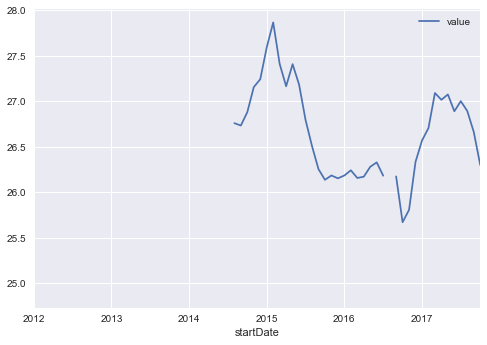

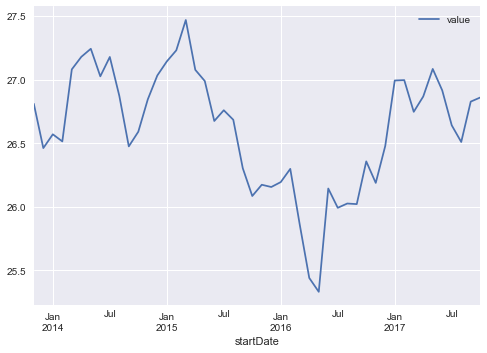

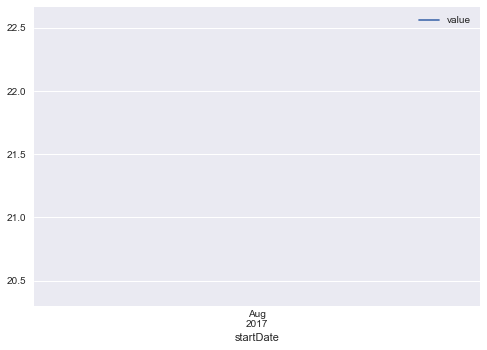

In [24]:
# BMI by month over the whole period
bmi_means = {}
for owner in bmi['owner'].unique():
    data_by_owner = bmi[bmi['owner'] == owner][['value']]
    resampled_data = data_by_owner.resample('M').mean()
    resampled_data.plot()
    print(resampled_data.describe())
    mean = resampled_data.describe().loc['mean', 'value']
    bmi_means[owner] = mean
    

In [25]:
for owner in bmi_means:
    print('Owner {} has monthly BMI mean of {}'.format(owner, bmi_means[owner]))

Owner 00000000-5951-4787-2497-ae32dc8d07d4 has monthly BMI mean of 21.4812765621
Owner 00000000-56ff-538b-2223-e1800b5e3ddb has monthly BMI mean of 26.6170523602
Owner 00000000-5851-ee08-eb34-e20acc5af74e has monthly BMI mean of 26.6131209286


           value
count  38.000000
mean    0.001571
std     0.015163
min    -0.019238
25%    -0.006506
50%     0.000864
75%     0.005267
max     0.075564
           value
count  47.000000
mean    0.000091
std     0.010275
min    -0.016711
25%    -0.007191
50%     0.001203
75%     0.004428
max     0.032079
       value
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN


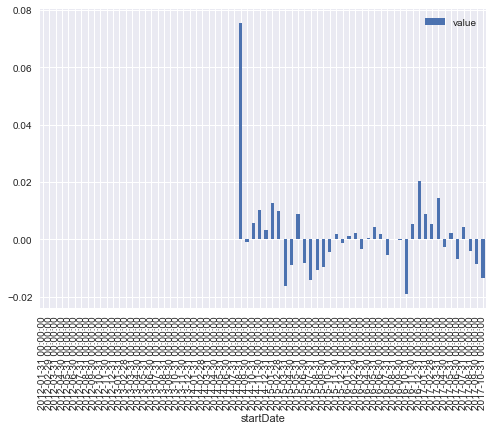

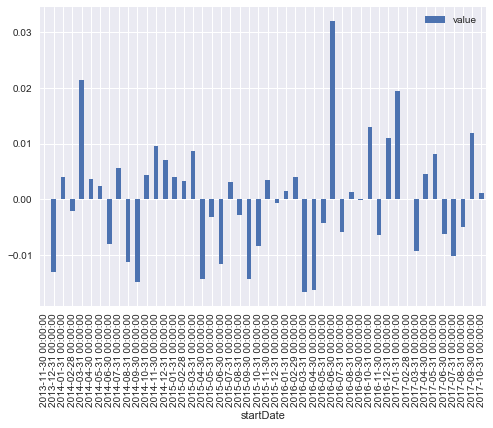

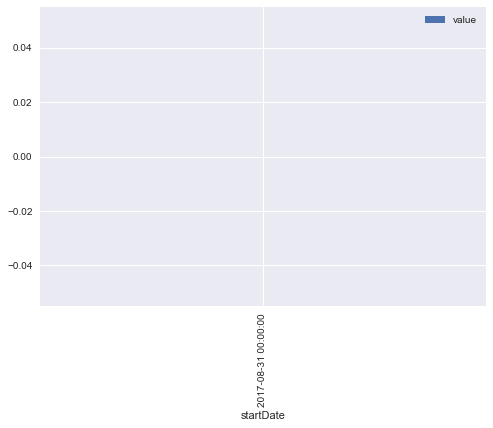

In [26]:
# pct_change slope comparison of each bmi
for owner in bmi['owner'].unique():
    data_by_owner = bmi[bmi['owner'] == owner][['value']]
    resampled_data = data_by_owner.resample('M').mean().pct_change()
    resampled_data.plot(kind='bar')
    print(resampled_data.describe())
    mean = resampled_data.describe().loc['mean', 'value']

In [27]:
weight = data_sample[data_sample['type'] == 'health-weight']
weight.index = weight['startDate']
weight['value'] = pd.Series(weight['value']).convert_objects(convert_numeric=True)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


00000000-56ff-538b-2223-e1800b5e3ddb
           value
count  39.000000
mean   70.698724
std     1.588081
min    65.700000
25%    69.577740
50%    70.830029
75%    71.859314
max    74.041000
00000000-5851-ee08-eb34-e20acc5af74e
           value
count  48.000000
mean   86.226737
std     1.539990
min    82.075113
25%    85.124421
50%    86.444431
75%    87.466679
max    89.002452
00000000-5951-4787-2497-ae32dc8d07d4
           value
count   5.000000
mean   59.692756
std     1.056491
min    58.740211
25%    58.967007
50%    59.193806
75%    60.327785
max    61.234970
d145b032-b7a5-4fa8-9887-b46598f4683a
            value
count    1.000000
mean   108.408488
std           NaN
min    108.408488
25%    108.408488
50%    108.408488
75%    108.408488
max    108.408488
00000000-584d-a4f0-bdee-d4102b989ce5
           value
count  12.000000
mean   71.574003
std     3.471932
min    66.700759
25%    68.837036
50%    70.465419
75%    74.959217
max    76.257950
00000000-584e-1f39-bdee-d4102b989d01
    

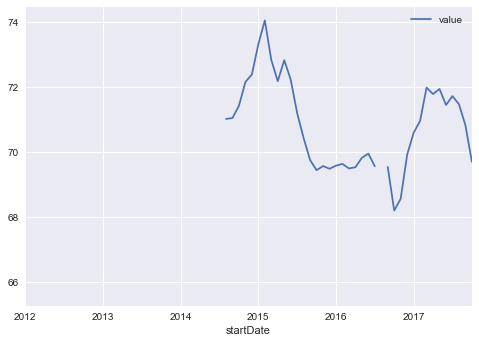

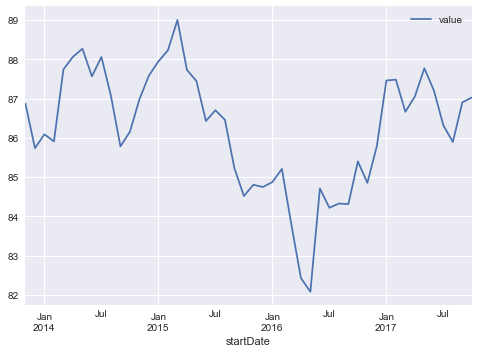

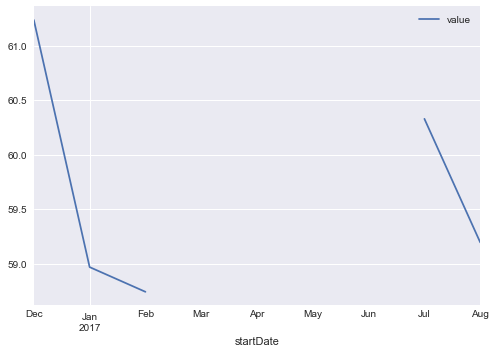

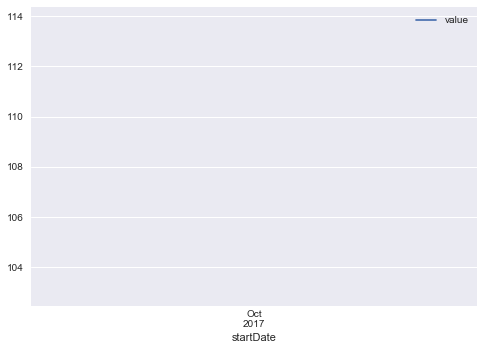

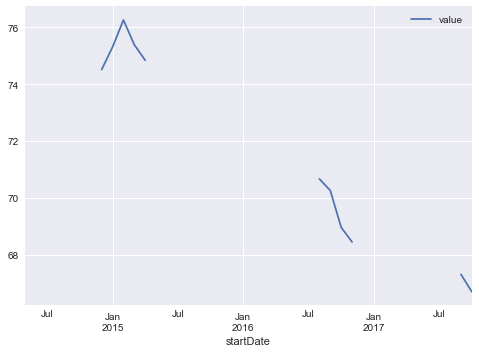

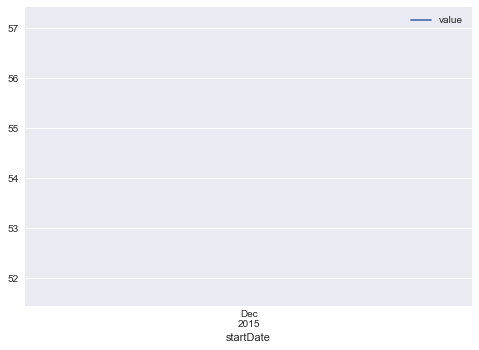

In [108]:
#weight over time
weight_info = {}
for owner in weight['owner'].unique():
    data_by_owner = weight[weight['owner'] == owner][['value']]
    resampled_data = data_by_owner.resample('M').mean()
    print(owner)
    resampled_data.plot()
    print(resampled_data.describe())
    mean = resampled_data.describe().loc['mean', 'value']
    min_ = data_by_owner.describe().loc['min', 'value']
    max_ = data_by_owner.describe().loc['max', 'value']
    weight_info[owner] = {'mean': mean, 'min': min_, 'max': max_}

In [29]:
# weight with means, mins, and maxs
for owner in weight_info:
    print('Owner {} has monthly weight mean of {}, min of {}, max of {}'.format(owner, weight_info[owner]['mean'],  weight_info[owner]['min'],  weight_info[owner]['max']))

Owner d145b032-b7a5-4fa8-9887-b46598f4683a has monthly weight mean of 108.408488, min of 108.408488, max of 108.408488
Owner 00000000-5951-4787-2497-ae32dc8d07d4 has monthly weight mean of 59.6927558335, min of 58.7402114868, max of 61.2349700928
Owner 00000000-5851-ee08-eb34-e20acc5af74e has monthly weight mean of 86.2267369248, min of 80.364, max of 90.9640045166
Owner 00000000-584e-1f39-bdee-d4102b989d01 has monthly weight mean of 54.4310844, min of 54.4310844, max of 54.4310844
Owner 00000000-584d-a4f0-bdee-d4102b989ce5 has monthly weight mean of 71.5740032601, min of 65.997689835, max of 77.56429527
Owner 00000000-56ff-538b-2223-e1800b5e3ddb has monthly weight mean of 70.6987244118, min of 65.7, max of 77.2030029297


In [148]:

# biggest change in a month period
for owner in weight_info:
    #print "Owner {}: ".format(owner)
    a = weight[weight['owner'] == owner].groupby(pd.TimeGrouper("M"))
    print("\nNEXT USER\n")
    for i, j in a:
        #j = j.dropna(axis = 1, how = 'all')
        maxi = j.max()
        mini = j.min()
        try:
            if maxi['startDate'] < mini['startDate']:
                diff = maxi['value'] - mini['value']
            else:
                diff = mini['value'] - maxi['value']
            #diff = j.max()['value'] - j.min()['value'] #max - min always gets a positive so we should be taking the starting weight - the end weight 
            print ("Weight change in the month of {} for user {} is {}".format(maxi['startDate'], owner, diff))
        except(KeyError):
            None
    #plt.plot(a)
    #plt.show()


NEXT USER

Weight change in the month of 2017-10-07 00:49:08.205000 for user d145b032-b7a5-4fa8-9887-b46598f4683a is 0.0

NEXT USER

Weight change in the month of 2016-12-22 08:50:22.400000 for user 00000000-5951-4787-2497-ae32dc8d07d4 is 0.0
Weight change in the month of 2017-01-26 02:04:03.779000 for user 00000000-5951-4787-2497-ae32dc8d07d4 is 0.0
Weight change in the month of 2017-02-01 17:35:16.484000 for user 00000000-5951-4787-2497-ae32dc8d07d4 is 0.0
Weight change in the month of nan for user 00000000-5951-4787-2497-ae32dc8d07d4 is nan
Weight change in the month of nan for user 00000000-5951-4787-2497-ae32dc8d07d4 is nan
Weight change in the month of nan for user 00000000-5951-4787-2497-ae32dc8d07d4 is nan
Weight change in the month of nan for user 00000000-5951-4787-2497-ae32dc8d07d4 is nan
Weight change in the month of 2017-07-07 22:17:46.850000 for user 00000000-5951-4787-2497-ae32dc8d07d4 is 0.0
Weight change in the month of 2017-08-04 03:04:23.029000 for user 00000000-595

Weight change in the month of 2015-10-23 15:32:56 for user 00000000-56ff-538b-2223-e1800b5e3ddb is -0.959007263184
Weight change in the month of 2015-11-30 16:30:35 for user 00000000-56ff-538b-2223-e1800b5e3ddb is -1.62000714111
Weight change in the month of 2015-12-28 15:44:37 for user 00000000-56ff-538b-2223-e1800b5e3ddb is -1.15900476074
Weight change in the month of 2016-01-29 14:29:49 for user 00000000-56ff-538b-2223-e1800b5e3ddb is -1.98600079346
Weight change in the month of 2016-02-25 16:01:58 for user 00000000-56ff-538b-2223-e1800b5e3ddb is -1.98900354004
Weight change in the month of 2016-03-30 15:10:48 for user 00000000-56ff-538b-2223-e1800b5e3ddb is -1.33700384521
Weight change in the month of 2016-04-20 14:49:50 for user 00000000-56ff-538b-2223-e1800b5e3ddb is -3.66210939262e-06
Weight change in the month of 2016-05-31 19:42:49 for user 00000000-56ff-538b-2223-e1800b5e3ddb is -1.25100445557
Weight change in the month of 2016-06-25 14:34:57 for user 00000000-56ff-538b-2223-

In [149]:
avgsteps = data_sample[data_sample['type'] == 'health-step-count']
avgsteps.index = avgsteps['startDate']
avgsteps['value'] = pd.Series(avgsteps['value']).convert_objects(convert_numeric=True)
#avgsteps = avgsteps.resample('M').mean()

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [150]:
# correlation from weight change per month and avg steps per month
month = np.asarray([])
owners = np.asarray([])
month_weight = np.asarray([])
month_avg_steps = np.asarray([])
for owner in weight_info:
    print "For owner: {}\n".format(owner)
    data_by_owner = avgsteps[avgsteps['owner'] == owner][['value']].groupby(pd.TimeGrouper("M"))
    
    hold = {}
    wc = []
    for i,j in data_by_owner:
        hold[(i.month, i.year)] = j['value'].mean()
    
    a = weight[weight['owner'] == owner].groupby(pd.TimeGrouper("M"))
    for i, j in a:
        print("j:", type(j.head(1)))
        #j = j.dropna(axis = 1, how = 'all')
        maxi = j.max()
        mini = j.min()
        try:
            month = np.append(month, maxi['startDate'])
            owners = np.append(owners, owner)
            if maxi['startDate'] < mini['startDate']:
                diff = maxi['value'] - mini['value']
            else:
                diff = mini['value'] - maxi['value']
            #diff = j.max()['value'] - j.min()['value']
            wc.append(diff)
            month_weight = np.append(month_weight, diff)
            
            k = maxi['startDate'].month
            l = maxi['startDate'].year
            print("    For {} of {}:".format(calendar.month_name[k], l))
            print("        Weight change: {}".format(diff))
            if (k, l) in hold.keys():
                print("        Average steps: {}".format(hold[(k,l)]))
                month_avg_steps = np.append(month_avg_steps, hold[(k,l)])
                print("\n")
            else:
                print("        No step data for this month.\n")
                month_avg_steps = np.append(month_avg_steps, np.nan)
        except(KeyError, AttributeError):
            month_avg_steps = np.append(month_avg_steps, np.nan)
    #print("    Average monthly weight change: {}".format(np.mean(month_weight.dropna(axis=0, how = "all"))))
    print("\nNEXT USER\n")
    #plt.plot(a)
    #plt.show()

For owner: d145b032-b7a5-4fa8-9887-b46598f4683a

('j:', <class 'pandas.core.frame.DataFrame'>)
    For October of 2017:
        Weight change: 0.0
        Average steps: 130.748175182



NEXT USER

For owner: 00000000-5951-4787-2497-ae32dc8d07d4

('j:', <class 'pandas.core.frame.DataFrame'>)
    For December of 2016:
        Weight change: 0.0
        No step data for this month.

('j:', <class 'pandas.core.frame.DataFrame'>)
    For January of 2017:
        Weight change: 0.0
        No step data for this month.

('j:', <class 'pandas.core.frame.DataFrame'>)
    For February of 2017:
        Weight change: 0.0
        No step data for this month.

('j:', <class 'pandas.core.frame.DataFrame'>)
('j:', <class 'pandas.core.frame.DataFrame'>)
('j:', <class 'pandas.core.frame.DataFrame'>)
('j:', <class 'pandas.core.frame.DataFrame'>)
('j:', <class 'pandas.core.frame.DataFrame'>)
    For July of 2017:
        Weight change: 0.0
        No step data for this month.

('j:', <class 'pandas.core

('j:', <class 'pandas.core.frame.DataFrame'>)
('j:', <class 'pandas.core.frame.DataFrame'>)
('j:', <class 'pandas.core.frame.DataFrame'>)
('j:', <class 'pandas.core.frame.DataFrame'>)
    For September of 2017:
        Weight change: 0.0
        Average steps: 184.766189502


('j:', <class 'pandas.core.frame.DataFrame'>)
    For October of 2017:
        Weight change: -1.40613911551
        Average steps: 179.088



NEXT USER

For owner: 00000000-56ff-538b-2223-e1800b5e3ddb

('j:', <class 'pandas.core.frame.DataFrame'>)
    For January of 2012:
        Weight change: 0.0
        No step data for this month.

('j:', <class 'pandas.core.frame.DataFrame'>)
('j:', <class 'pandas.core.frame.DataFrame'>)
('j:', <class 'pandas.core.frame.DataFrame'>)
('j:', <class 'pandas.core.frame.DataFrame'>)
('j:', <class 'pandas.core.frame.DataFrame'>)
('j:', <class 'pandas.core.frame.DataFrame'>)
('j:', <class 'pandas.core.frame.DataFrame'>)
('j:', <class 'pandas.core.frame.DataFrame'>)
('j:', <class 'p

In [151]:
month.shape

(171L,)

In [152]:
owners.shape

(171L,)

In [153]:
month_avg_steps.shape

(171L,)

In [154]:
month_weight.shape

(171L,)

In [155]:
d = {
    "start_date": month,
    "owner": owners,
    "second": month_weight,
    "first": month_avg_steps,
}
df = pd.DataFrame(data=d)
#df = df.dropna()
df.index = df['start_date']
df['owner'].unique()

array(['d145b032-b7a5-4fa8-9887-b46598f4683a',
       '00000000-5951-4787-2497-ae32dc8d07d4',
       '00000000-5851-ee08-eb34-e20acc5af74e',
       '00000000-584e-1f39-bdee-d4102b989d01',
       '00000000-584d-a4f0-bdee-d4102b989ce5',
       '00000000-56ff-538b-2223-e1800b5e3ddb'], dtype=object)

Owner d145b032-b7a5-4fa8-9887-b46598f4683a has r of nan and p of nan


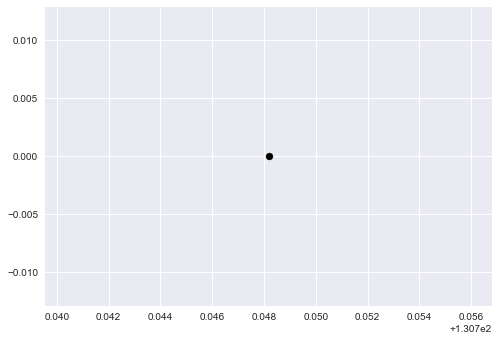

not long enough
Not enough info
Owner 00000000-5851-ee08-eb34-e20acc5af74e has r of -0.0598424088874 and p of 0.91034353791


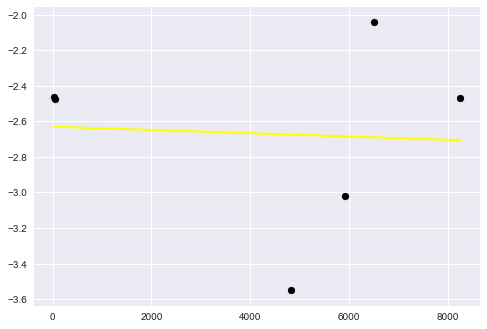

not long enough
Not enough info
Owner 00000000-584d-a4f0-bdee-d4102b989ce5 has r of 1.0 and p of 0.0


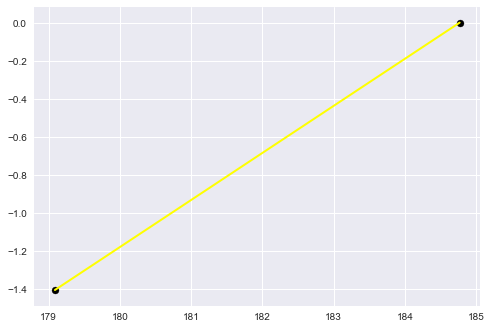

Owner 00000000-56ff-538b-2223-e1800b5e3ddb has r of -0.143739426018 and p of 0.502808079413


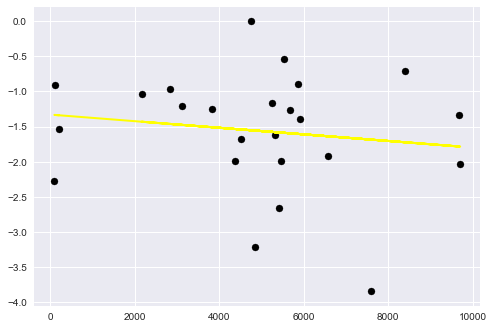

In [156]:
for owner in df['owner'].unique():
    df_temp = df[df['owner']==owner]
    
    r, p = plotter(df_temp)
    if r == -5:
        print("Not enough info")
    else:
        print('Owner {} has r of {} and p of {}'.format(owner, r, p))
    plt.show()